In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filepath = "./battery/1585 Ga raw.xlsx"

In [3]:
DODI_C_20 = pd.read_excel(filepath, sheet_name = 0,engine = "openpyxl", header = None)
PROD_C_20 = pd.read_excel(filepath, sheet_name = 1,engine = "openpyxl", header = None)
DODI_D_20 = pd.read_excel(filepath, sheet_name = 2,engine = "openpyxl", header = None)
PROD_D_20 = pd.read_excel(filepath, sheet_name = 3,engine = "openpyxl", header = None)
DODI_C_rt = pd.read_excel(filepath, sheet_name = 4,engine = "openpyxl", header = None)
PROD_C_rt = pd.read_excel(filepath, sheet_name = 5,engine = "openpyxl", header = None)
DODI_D_rt = pd.read_excel(filepath, sheet_name = 6,engine = "openpyxl", header = None)
PROD_D_rt = pd.read_excel(filepath, sheet_name = 7,engine = "openpyxl", header = None)
DODI_C_60 = pd.read_excel(filepath, sheet_name = 8,engine = "openpyxl", header = None)
PROD_C_60 = pd.read_excel(filepath, sheet_name = 9,engine = "openpyxl", header = None)
DODI_D_60 = pd.read_excel(filepath, sheet_name = 10,engine = "openpyxl", header = None)
PROD_D_60 = pd.read_excel(filepath, sheet_name = 11,engine = "openpyxl", header = None)

batteryListName= [
    ['DODI_C_20','DODI_C_rt','DODI_C_60'],
    ['DODI_D_20','DODI_D_rt','DODI_D_60'],
    ['PROD_C_20','PROD_C_rt','PROD_C_60'],
    ['PROD_D_20','PROD_D_rt','PROD_D_60']
]

batteryList = [
    [DODI_C_20, DODI_C_rt, DODI_C_60],
    [DODI_D_20,DODI_D_rt,DODI_D_60],
    [PROD_C_20,PROD_C_rt,PROD_C_60],
    [PROD_D_20,PROD_D_rt,PROD_D_60]
]

for i in range(0,4):
    for j in range(0,3):
        dataSet = batteryList[i][j]
        dataSet.replace('', np.nan, inplace=True)

In [4]:
def printBatteryData():
    count = 1
    plt.figure(figsize=(16,16))
    for i in range(0,4):
        for j in range(0,3):
            dataSet = batteryList[i][j]
            plt.subplot(4,3,count)
            plt.title(batteryListName[i][j])
            for k in range(1, (int)(dataSet.shape[1])-1, 2):
                plt.plot(dataSet.iloc[:,[k+1]], dataSet.iloc[:,[k]])
            plt.xlabel('coulomb')
            plt.ylabel('Volatage')
            count += 1

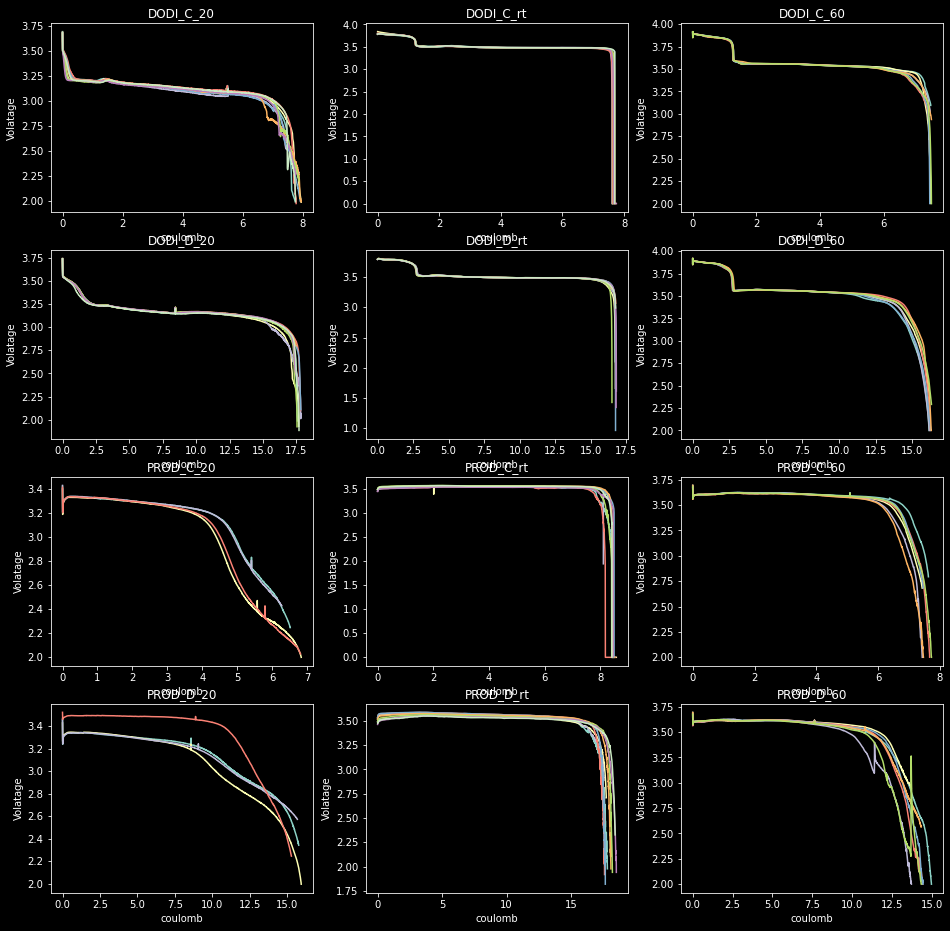

In [5]:
printBatteryData()

In [6]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv3D, Conv1D
from sklearn.model_selection import KFold

In [7]:
kfold_num = 5
window_size = 20
horizon = 1
filters = 512
kernel_size = 3
dimension = 3
epochs = 30
batch_size = 50

In [8]:
class DataPreprocessing:
    def getSequence(dataFrame, temp, i):
        seq = dataFrame.iloc[:,[2*i,2*i+1]].copy()
        seq.dropna(axis=0, inplace=True)
        seq = seq.to_numpy()
        tempSeq = np.array(seq.shape[0], dtype = float)
        tempSeq = np.full((seq.shape[0],1),temp)
        seq = np.append(seq, tempSeq[:,-1:], axis = 1)
        return seq
    #시계열 데이터를 윈도우 단위로 자르는 함수
    def seq2dataset(seq,window,horizon):
        X=[]; Y=[]
        for i in range(len(seq)-(window+horizon)+1):
            x=seq[i:(i+window)]
            y=(seq[i+window+horizon-1])
            X.append(x); Y.append(y)
        return np.array(X), np.array(Y)

Text(0, 0.5, 'Volatage')

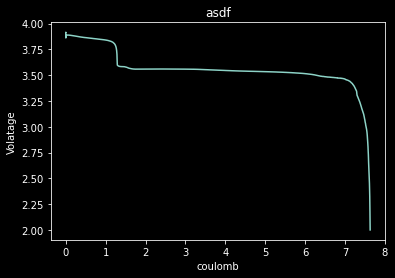

In [9]:
plt.title("asdf")
df = DODI_C_60.iloc[:,[0,1]].copy()
plt.plot(df.iloc[:,[0]], df.iloc[:,[1]])
plt.xlabel('coulomb')
plt.ylabel('Volatage')

In [10]:
class DrawPlot:
    def drawValidCurve(hist):
        plt.plot(hist.history['mae'])
        plt.plot(hist.history['val_mae'])
        plt.title('Model mae')
        plt.ylabel('mae')
        plt.xlabel('Epoch')
        plt.legend(['Train','Validation'], loc='best')
        plt.grid()
        plt.show()
    
    def drawPrediction(i,j,pred,y_test):
        plt.figure(figsize=(8,8))
        x_range=range(y_test.shape[0])
        plt.plot(x_range,y_test[x_range,1],color='red',linestyle='dotted')
        plt.plot(x_range,pred[x_range,1],color='green',linestyle='dashed')
        plt.title(batteryListName[i][j])
        plt.legend(['True value','Predicted value'], loc='best')
        plt.grid()
        plt.show()
        

In [11]:
def deepLearn(dataList):
    for num1 in range(0,2):
        for num2 in range(0,3):
            if num2==0:
                temp = -20
            elif num2==1:
                temp = 20
            else:
                temp = 60
            dataFrame = dataList[num1][num2]
            len = (int)(dataFrame.shape[1]/2)
            for i in range(len):
                seq = DataPreprocessing.getSequence(dataFrame, temp, i)
                
                kfold = KFold(n_splits=kfold_num)
                
                X,Y = DataPreprocessing.seq2dataset(seq,window_size,horizon)
                for train_idx, test_idx in kfold.split(X):
                    x_train, x_test = X[train_idx],X[test_idx]
                    y_train, y_test = Y[train_idx],Y[test_idx]

                    model = Sequential()
                    model.add(Conv1D(filters = filters, kernel_size = kernel_size, input_shape = (window_size, dimension),padding = 'same', activation = 'relu'))
                    model.add(Dropout(0.2))
                    model.add(Conv1D(filters = filters, kernel_size = kernel_size, padding = 'same', activation = 'relu'))
                    model.add(Dropout(0.2))
                    model.add(LSTM(units=64,input_shape=x_train[0].shape, return_sequences=True))
                    model.add(LSTM(units=64, return_sequences=False))
                    model.add(Dense(3))
                    model.compile(loss='mae')
                    model.compile(loss='mae', optimizer='adam', metrics='mae')
                    hist=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test),verbose=1)

                    ev=model.evaluate(x_test,y_test,verbose=1)
                    print("손실 함수:", ev[0], "MAE:", ev[1])

                    pred=model.predict(x_test)
                    
                    # division = x_test.shape[0]
                    print("LSTM 평균절댓값백분율오차(MAPE):",sum(abs(y_test-pred)/y_test)/x_test.shape[0])

                    DrawPlot.drawValidCurve(hist)

                    pred = model.predict(X)
                    y_test = Y
                    
                    DrawPlot.drawPrediction(num1, num2, pred, y_test)

                    model.save('./ohs_model')
            

Epoch 1/30
58/58 [==============================] - 5s 67ms/step - loss: 5.5092 - mae: 5.5092 - val_loss: 4.6975 - val_mae: 4.6975
Epoch 2/30
58/58 [==============================] - 2s 42ms/step - loss: 3.0757 - mae: 3.0757 - val_loss: 3.0763 - val_mae: 3.0763
Epoch 3/30
58/58 [==============================] - 2s 39ms/step - loss: 1.5980 - mae: 1.5980 - val_loss: 1.6281 - val_mae: 1.6281
Epoch 4/30
58/58 [==============================] - 2s 36ms/step - loss: 0.6103 - mae: 0.6103 - val_loss: 1.3501 - val_mae: 1.3501
Epoch 5/30
58/58 [==============================] - 2s 36ms/step - loss: 0.5454 - mae: 0.5454 - val_loss: 1.2852 - val_mae: 1.2852
Epoch 6/30
58/58 [==============================] - 2s 36ms/step - loss: 0.5464 - mae: 0.5464 - val_loss: 1.3677 - val_mae: 1.3677
Epoch 7/30
58/58 [==============================] - 2s 36ms/step - loss: 0.5464 - mae: 0.5464 - val_loss: 1.3612 - val_mae: 1.3612
Epoch 8/30
58/58 [==============================] - 2s 36ms/step - loss: 0.5466 - m

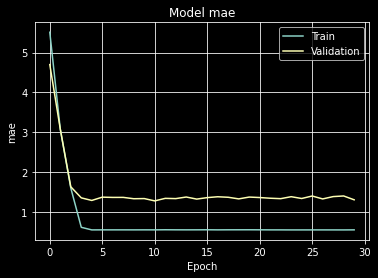

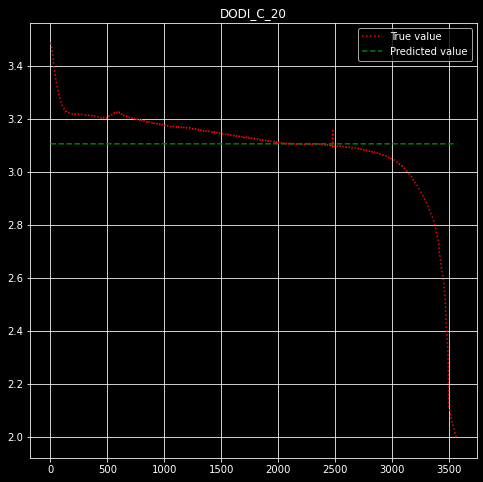

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
58/58 [==============================] - 5s 66ms/step - loss: 5.5568 - mae: 5.5568 - val_loss: 4.0934 - val_mae: 4.0934
Epoch 2/30
58/58 [==============================] - 2s 38ms/step - loss: 3.2317 - mae: 3.2317 - val_loss: 2.5822 - val_mae: 2.5822
Epoch 3/30
58/58 [==============================] - 2s 37ms/step - loss: 1.8527 - mae: 1.8527 - val_loss: 1.3072 - val_mae: 1.3072
Epoch 4/30
58/58 [==============================] - 2s 41ms/step - loss: 0.8076 - mae: 0.8076 - val_loss: 0.7704 - val_mae: 0.7704
Epoch 5/30
58/58 [==============================] - 2s 39ms/step - loss: 0.6874 - mae: 0.6874 - val_loss: 0.7669 - val_mae: 0.7669
Epoch 6/30
58/58 [==============================] - 2s 38ms/step - loss: 0.6832 - mae: 0.6832 - val_loss: 0.8031 - val_mae: 0.8031
Epoch 7/30
58/58 [==============================] - 2s 39ms/step - loss: 0.6835 - mae: 0.6835 - val_loss: 0.7780 - val_mae: 0.7780
Epoch 8/30
58/58 [==============================] - 2s 37ms/step - loss: 0.6840 - m

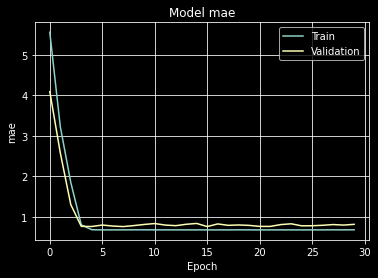

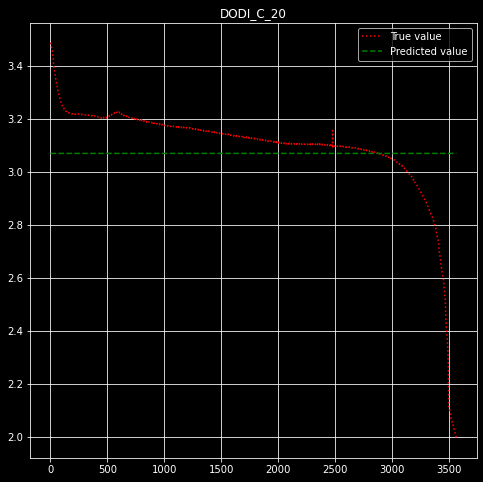

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
58/58 [==============================] - 5s 65ms/step - loss: 5.6892 - mae: 5.6892 - val_loss: 3.4389 - val_mae: 3.4389
Epoch 2/30
58/58 [==============================] - 2s 36ms/step - loss: 3.1555 - mae: 3.1555 - val_loss: 1.7274 - val_mae: 1.7274
Epoch 3/30
58/58 [==============================] - 2s 37ms/step - loss: 1.5862 - mae: 1.5862 - val_loss: 0.2936 - val_mae: 0.2936
Epoch 4/30
58/58 [==============================] - 2s 39ms/step - loss: 0.8403 - mae: 0.8403 - val_loss: 0.2092 - val_mae: 0.2092
Epoch 5/30
58/58 [==============================] - 2s 42ms/step - loss: 0.8178 - mae: 0.8178 - val_loss: 0.1495 - val_mae: 0.1495
Epoch 6/30
58/58 [==============================] - 2s 36ms/step - loss: 0.8176 - mae: 0.8176 - val_loss: 0.1840 - val_mae: 0.1840
Epoch 7/30
58/58 [==============================] - 2s 36ms/step - loss: 0.8180 - mae: 0.8180 - val_loss: 0.2734 - val_mae: 0.2734
Epoch 8/30
58/58 [==============================] - 2s 36ms/step - loss: 0.8166 - m

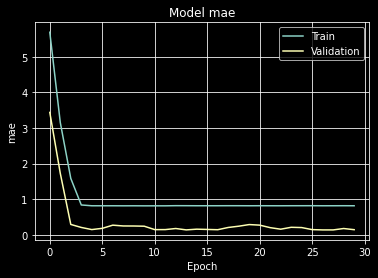

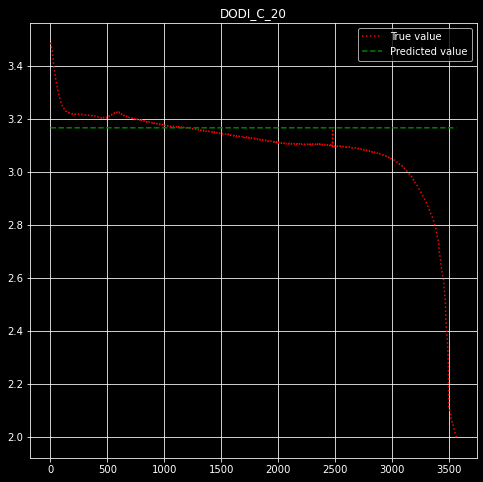

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
58/58 [==============================] - 5s 66ms/step - loss: 5.4604 - mae: 5.4604 - val_loss: 3.7070 - val_mae: 3.7070
Epoch 2/30
58/58 [==============================] - 2s 37ms/step - loss: 2.8059 - mae: 2.8059 - val_loss: 2.2006 - val_mae: 2.2006
Epoch 3/30
58/58 [==============================] - 2s 36ms/step - loss: 1.3296 - mae: 1.3296 - val_loss: 0.8441 - val_mae: 0.8441
Epoch 4/30
58/58 [==============================] - 2s 37ms/step - loss: 0.7034 - mae: 0.7034 - val_loss: 0.8393 - val_mae: 0.8393
Epoch 5/30
58/58 [==============================] - 2s 40ms/step - loss: 0.6889 - mae: 0.6889 - val_loss: 0.8489 - val_mae: 0.8489
Epoch 6/30
58/58 [==============================] - 2s 37ms/step - loss: 0.6887 - mae: 0.6887 - val_loss: 0.8366 - val_mae: 0.8366
Epoch 7/30
58/58 [==============================] - 2s 37ms/step - loss: 0.6884 - mae: 0.6884 - val_loss: 0.8136 - val_mae: 0.8136
Epoch 8/30
58/58 [==============================] - 2s 41ms/step - loss: 0.6876 - m

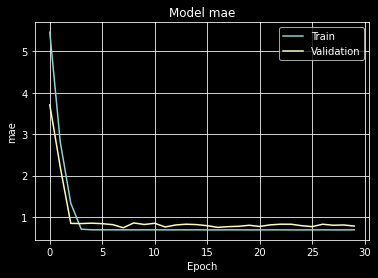

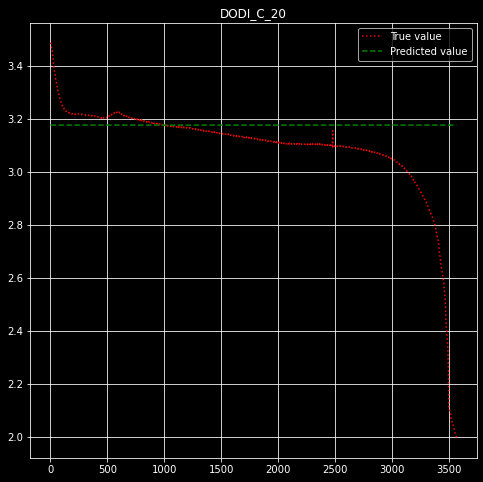

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
58/58 [==============================] - 6s 68ms/step - loss: 5.3892 - mae: 5.3892 - val_loss: 4.4967 - val_mae: 4.4967
Epoch 2/30
58/58 [==============================] - 2s 37ms/step - loss: 2.8080 - mae: 2.8080 - val_loss: 2.8530 - val_mae: 2.8530
Epoch 3/30
58/58 [==============================] - 2s 37ms/step - loss: 1.2564 - mae: 1.2564 - val_loss: 1.4280 - val_mae: 1.4280
Epoch 4/30
58/58 [==============================] - 2s 38ms/step - loss: 0.5635 - mae: 0.5635 - val_loss: 1.4459 - val_mae: 1.4459
Epoch 5/30
58/58 [==============================] - 2s 39ms/step - loss: 0.5390 - mae: 0.5390 - val_loss: 1.3961 - val_mae: 1.3961
Epoch 6/30
58/58 [==============================] - 2s 38ms/step - loss: 0.5397 - mae: 0.5397 - val_loss: 1.3881 - val_mae: 1.3881
Epoch 7/30
58/58 [==============================] - 2s 37ms/step - loss: 0.5396 - mae: 0.5396 - val_loss: 1.3522 - val_mae: 1.3522
Epoch 8/30
58/58 [==============================] - 2s 37ms/step - loss: 0.5400 - m

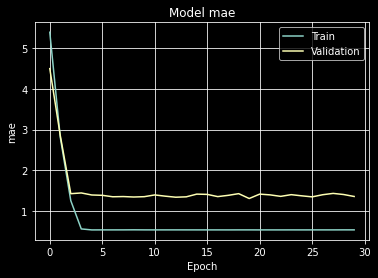

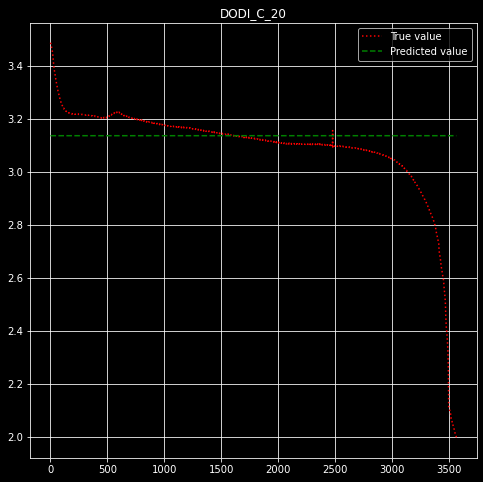

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
61/61 [==============================] - 14s 124ms/step - loss: 5.5809 - mae: 5.5809 - val_loss: 4.6707 - val_mae: 4.6707
Epoch 2/30
61/61 [==============================] - 5s 87ms/step - loss: 2.9567 - mae: 2.9567 - val_loss: 3.0066 - val_mae: 3.0066
Epoch 3/30
61/61 [==============================] - 4s 70ms/step - loss: 1.4431 - mae: 1.4431 - val_loss: 1.4615 - val_mae: 1.4615
Epoch 4/30
61/61 [==============================] - 4s 68ms/step - loss: 0.5977 - mae: 0.5977 - val_loss: 1.4054 - val_mae: 1.4054
Epoch 5/30
61/61 [==============================] - 4s 69ms/step - loss: 0.5808 - mae: 0.5808 - val_loss: 1.4001 - val_mae: 1.4001
Epoch 6/30
61/61 [==============================] - 3s 57ms/step - loss: 0.5814 - mae: 0.5814 - val_loss: 1.4618 - val_mae: 1.4618
Epoch 7/30
61/61 [==============================] - 4s 63ms/step - loss: 0.5807 - mae: 0.5807 - val_loss: 1.4107 - val_mae: 1.4107
Epoch 8/30
61/61 [==============================] - 4s 62ms/step - loss: 0.5804 -

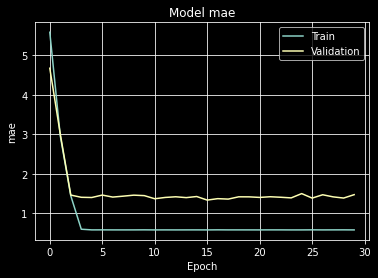

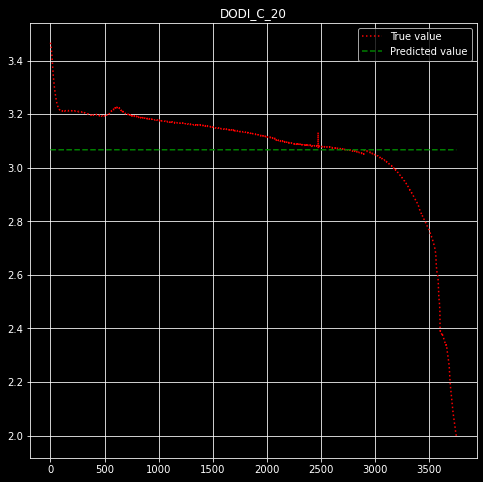

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
61/61 [==============================] - 13s 126ms/step - loss: 5.4752 - mae: 5.4752 - val_loss: 3.8866 - val_mae: 3.8866
Epoch 2/30
61/61 [==============================] - 5s 87ms/step - loss: 2.9752 - mae: 2.9752 - val_loss: 2.1993 - val_mae: 2.1993
Epoch 3/30
61/61 [==============================] - 6s 96ms/step - loss: 1.3755 - mae: 1.3755 - val_loss: 0.9271 - val_mae: 0.9271
Epoch 4/30
61/61 [==============================] - 4s 73ms/step - loss: 0.7330 - mae: 0.7330 - val_loss: 0.8487 - val_mae: 0.8487
Epoch 5/30
61/61 [==============================] - 4s 67ms/step - loss: 0.7208 - mae: 0.7208 - val_loss: 0.8884 - val_mae: 0.8884
Epoch 6/30
61/61 [==============================] - 4s 60ms/step - loss: 0.7202 - mae: 0.7202 - val_loss: 0.9497 - val_mae: 0.9497
Epoch 7/30
61/61 [==============================] - 4s 67ms/step - loss: 0.7218 - mae: 0.7218 - val_loss: 0.8686 - val_mae: 0.8686
Epoch 8/30
61/61 [==============================] - 4s 64ms/step - loss: 0.7219 -

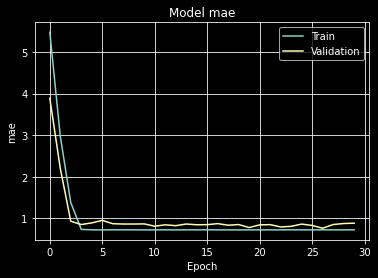

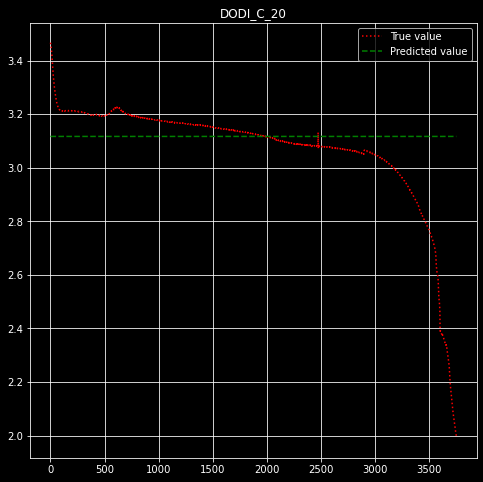

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
61/61 [==============================] - 12s 132ms/step - loss: 5.5554 - mae: 5.5554 - val_loss: 3.2308 - val_mae: 3.2308
Epoch 2/30
61/61 [==============================] - 5s 82ms/step - loss: 3.0379 - mae: 3.0379 - val_loss: 1.6391 - val_mae: 1.6391
Epoch 3/30
61/61 [==============================] - 5s 86ms/step - loss: 1.4797 - mae: 1.4797 - val_loss: 0.3598 - val_mae: 0.3598
Epoch 4/30
61/61 [==============================] - 4s 62ms/step - loss: 0.8710 - mae: 0.8710 - val_loss: 0.2841 - val_mae: 0.2841
Epoch 5/30
61/61 [==============================] - 4s 70ms/step - loss: 0.8609 - mae: 0.8609 - val_loss: 0.1927 - val_mae: 0.1927
Epoch 6/30
61/61 [==============================] - 5s 81ms/step - loss: 0.8612 - mae: 0.8612 - val_loss: 0.2089 - val_mae: 0.2089
Epoch 7/30
61/61 [==============================] - 4s 66ms/step - loss: 0.8610 - mae: 0.8610 - val_loss: 0.2244 - val_mae: 0.2244
Epoch 8/30
61/61 [==============================] - 4s 64ms/step - loss: 0.8601 -

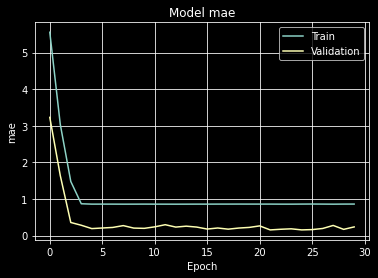

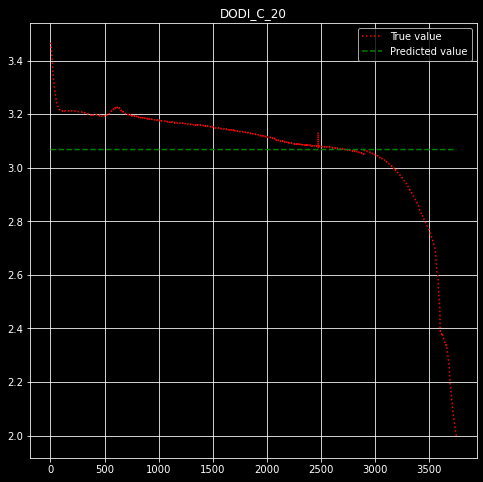

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
61/61 [==============================] - 15s 174ms/step - loss: 5.3573 - mae: 5.3573 - val_loss: 3.8028 - val_mae: 3.8028
Epoch 2/30
61/61 [==============================] - 5s 89ms/step - loss: 2.9263 - mae: 2.9263 - val_loss: 2.3387 - val_mae: 2.3387
Epoch 3/30
61/61 [==============================] - 4s 70ms/step - loss: 1.4043 - mae: 1.4043 - val_loss: 0.8736 - val_mae: 0.8736
Epoch 4/30
61/61 [==============================] - 4s 66ms/step - loss: 0.7367 - mae: 0.7367 - val_loss: 0.8395 - val_mae: 0.8395
Epoch 5/30
61/61 [==============================] - 4s 65ms/step - loss: 0.7220 - mae: 0.7220 - val_loss: 0.7925 - val_mae: 0.7925
Epoch 6/30
61/61 [==============================] - 5s 90ms/step - loss: 0.7212 - mae: 0.7212 - val_loss: 0.9194 - val_mae: 0.9194
Epoch 7/30
61/61 [==============================] - 4s 62ms/step - loss: 0.7233 - mae: 0.7233 - val_loss: 0.8554 - val_mae: 0.8554
Epoch 8/30
61/61 [==============================] - 4s 64ms/step - loss: 0.7223 -

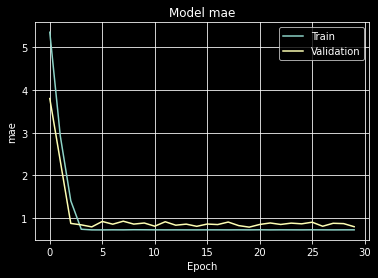

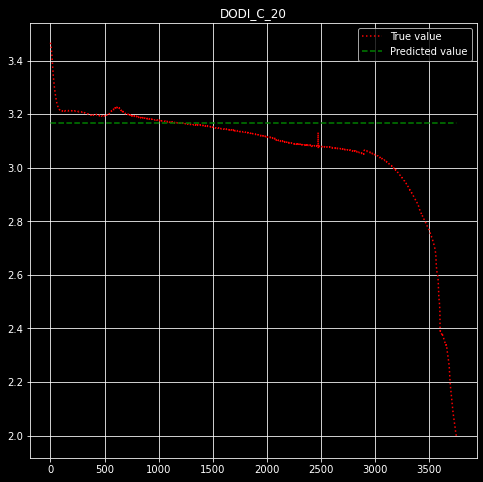

INFO:tensorflow:Assets written to: ./ohs_model/assets


INFO:tensorflow:Assets written to: ./ohs_model/assets


Epoch 1/30
61/61 [==============================] - 13s 123ms/step - loss: 5.2492 - mae: 5.2492 - val_loss: 4.5273 - val_mae: 4.5273
Epoch 2/30
61/61 [==============================] - 6s 97ms/step - loss: 2.9190 - mae: 2.9190 - val_loss: 3.0872 - val_mae: 3.0872
Epoch 3/30
61/61 [==============================] - 5s 82ms/step - loss: 1.3973 - mae: 1.3973 - val_loss: 1.4773 - val_mae: 1.4773
Epoch 4/30
61/61 [==============================] - 5s 76ms/step - loss: 0.5842 - mae: 0.5842 - val_loss: 1.4913 - val_mae: 1.4913
Epoch 5/30
61/61 [==============================] - 4s 69ms/step - loss: 0.5670 - mae: 0.5670 - val_loss: 1.4424 - val_mae: 1.4424
Epoch 6/30
61/61 [==============================] - 5s 83ms/step - loss: 0.5673 - mae: 0.5673 - val_loss: 1.4495 - val_mae: 1.4495
Epoch 7/30
61/61 [==============================] - 5s 77ms/step - loss: 0.5666 - mae: 0.5666 - val_loss: 1.4778 - val_mae: 1.4778
Epoch 8/30
61/61 [==============================] - 5s 74ms/step - loss: 0.5670 -

KeyboardInterrupt: 

In [12]:
deepLearn(batteryList)